## Multi-class Classification and Neural Networks¶

We will implement one-vs-all logistic regression and neural networks to recognize handwritten digits

In [1]:
# manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization 
from scipy import optimize

# load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

data set in ex3data1.mat that contains 5000 training examples of handwritten digits (This is a subset of the MNIST handwritten digit dataset). The .mat format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the .mat format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the loadmat function within the scipy.io module. This function returns a python dictionary with keys containing the variable names within the .mat file.

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$
The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

In [2]:
# 20x20 Input Images of Digits
input_layer_size  = 400


# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0


#number of rows aka training examples
m = y.size

In [3]:
print(f"We have, {len(data['X'])} training examples")

We have, 5000 training examples


In [4]:
# y is the numbers 1-9 (ordered) 5000 examples
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [5]:
# each image is 20 by 20 matrix, we need to vactorize that => we get a row of 400 pixles value for each number
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Visualizing the data¶

In [6]:
#choose random 10 number within the range of our m=5000
rand_indices = np.random.choice(m, size=100, replace=False)
#rand_indices[1:5] 

#acquire Xs with these indices
random_Xs = X[rand_indices, :]

In [7]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

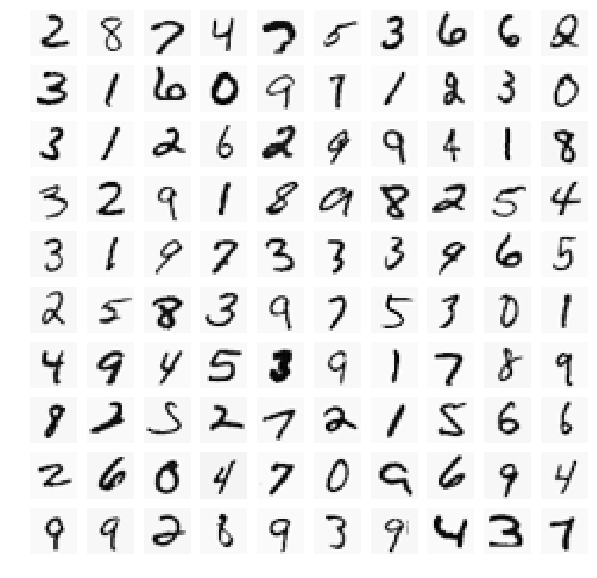

In [8]:
displayData(random_Xs)

## Vectorizing Logistic Regression

In [9]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

y_t = np.array([1, 0, 1, 0, 1])



# test value for the regularization parameter
lambda_t = 3

In [10]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))


Cost Function $$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$




Gradient

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

The function below return the cost and the gradients for unregulized logisitc regression/ we can feed that function to the optimizie function later on to get the optimized thetas for each number in our classifier

In [11]:
def lrCostFunction(theta, X, y, lambda_):
    
    m = X.shape[0]
    
    J = 0
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    
    grad = np.zeros(theta.shape)
    
    z = X.dot(theta.T)
    
    h = sigmoid(z)
    
    temp = theta
    temp[0] = 0
    
    
    J = (1/m) * np.sum(-y.dot(np.log(h)) - (1-y).dot(np.log(1-h))) + (lambda_ / (2*m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h-y).dot(X)
    
    grad = grad + (lambda_ / m) * temp

        
    # =============================================================
    return J, grad

In [12]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

In [13]:
print(f"Cost: {J}")
print('----')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))

Cost: 2.534819396109744
----
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


This funcion allows us to get the best theta values for each number

In [14]:
def oneVsAll(X,y, num_labels, lambda_):
    
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n+1))
    
    #Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='CG',
                                options=options) 
        
        all_theta[c] = res.x
        
        
    
    return all_theta


In [17]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

After we have optimized our thetas, we need to predict X * Theta and comapre them to our Ys to test how accurate our model is

In [18]:
def predictOneVsAll(all_theta, X):
    
    m = X.shape[0]
    
    p = np.zeros(m)
    
    
    X = np.concatenate([np.ones((m,1)), X], axis=1)
    
    z = X.dot(all_theta.T)
    
    
    
    #p = np.argmax(sigmoid(z))
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)
    
    return p

In [19]:
pred = predictOneVsAll(all_theta, X)

In [20]:
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.08%


In [21]:
m = X.shape[0]
p = np.zeros(m)
X = np.concatenate([np.ones((m,1)), X], axis=1)
z = X.dot(all_theta.T)



p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

In [22]:
print(f"all theta shape: {all_theta.shape} and X shape: {X.shape} / prediction shape: {p.shape}")

all theta shape: (10, 401) and X shape: (5000, 401)


(5000,)

(5000, 401)

In [26]:
#-------X---- 401 pixels

In [27]:
q = sigmoid(X.dot(all_theta.T))

In [28]:
sigmoid(X.dot(all_theta.T))

array([[9.99957766e-01, 8.17335148e-15, 3.76235402e-04, ...,
        5.11562994e-07, 1.01725453e-05, 1.70891722e-03],
       [9.99998418e-01, 4.33830164e-12, 2.86322280e-05, ...,
        8.92502412e-07, 4.96174567e-07, 5.34962952e-05],
       [9.99992272e-01, 1.22191263e-14, 3.00886497e-04, ...,
        1.78093153e-07, 2.36851221e-02, 1.21128231e-03],
       ...,
       [2.01790815e-11, 2.42669045e-02, 2.20866422e-03, ...,
        2.87643973e-05, 1.34826242e-03, 8.75350957e-01],
       [5.43094233e-09, 5.76521057e-11, 5.33968904e-09, ...,
        3.50170928e-04, 6.70419052e-02, 9.14207692e-01],
       [2.12085662e-03, 8.08499312e-17, 2.71380813e-05, ...,
        4.01500413e-01, 1.88560486e-03, 1.87175614e-01]])